In [1]:
from pytorch__my_vgg import Vgg
from tqdm import trange
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# ==================== Define Model ==================== #
model = Vgg(num_classes=10, custom_vgg=[1, 16, 64, 'P', 128, 256, 'P']).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
max_epochs = 5

In [3]:
# ==================== Load Mnist ==================== #

batch_size = 64

train_dataset = datasets.MNIST(root='./', download=True, train=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./', download=True, train=False, transform=transforms.ToTensor())

x_train = train_dataset.data.float()
y_train = train_dataset.targets
y_train_ohe = torch.nn.functional.one_hot(y_train)

train_dl = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
test_dl = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)

In [4]:
# ==================== Load Mnist ==================== #

test_acc = 0  # this one is not appended - it's just used as a starting point for t.set_description
training_losses = []
train_accuracies = []
test_accuracies = []

for i in (t := trange(max_epochs, ncols=150)):
    running_loss = 0
    running_train_acc = 0
    running_test_acc = 0
    for batch_index, (images, labels) in enumerate(train_dl):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        predicted_class = torch.argmax(outputs, dim=1)
        train_acc = (predicted_class == labels).float().mean()

        model.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        training_losses.append(loss.item())

        optimizer.step()

        t.set_description(
            f'Epoch: {i + 1}/{max_epochs}, batch: {batch_index} /{len(train_dl)} -  Train loss: {loss.item():.4f} | Train acc: {train_acc * 100:.2f}% | Test acc: {test_acc * 100:.2f}%')

    with torch.no_grad():
        for batch, (images_t, labels_t) in enumerate(test_dl):
            images_t = images_t.to(device)
            labels_t = labels_t.to(device)
            outputs = model(images_t)

            predicted_class_t = torch.argmax(outputs, dim=1)
            test_acc = (predicted_class_t == labels_t).float().mean()
            running_test_acc += test_acc.item()

    train_accuracies.append(running_train_acc / len(train_dl))
    test_accuracies.append(running_test_acc / len(test_dl))

Epoch: 5/5, batch: 937 /938 -  Train loss: 0.0001 | Train acc: 100.00% | Test acc: 100.00%: 100%|██████████████████████| 5/5 [11:14<00:00, 134.82s/it]


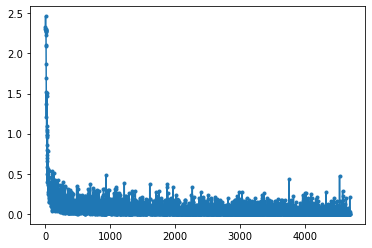

In [5]:
plt.plot(training_losses, '.-')